# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6049 sha256=b1a21e585cc356c33cc2ba31c5ea37317074691fa4a3c27c6957bfc24ae067ce
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
# LOOKUP_STEPS = [1, 2, 3]

# Tomorrow to five days in future (including the fifth day)
LOOKUP_STEPS = [1, 2, 3, 4, 5]

# Stock ticker, AMD
STOCK = 'AMD'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
u01_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [5]:
u01_df.head()

,open,high,low,close,adjclose,volume,ticker
2021-05-10,78.199997,78.300003,75.919998,75.989998,75.989998,45134500,AMD
2021-05-11,73.570000,76.930000,72.750000,76.830002,76.830002,51008200,AMD
2021-05-12,75.089996,76.129997,74.160004,74.639999,74.639999,42531400,AMD
2021-05-13,75.209999,75.699997,72.500000,73.089996,73.089996,48646800,AMD
2021-05-14,74.019997,75.029999,72.720001,74.589996,74.589996,38355800,AMD


In [6]:
!date

Thu May 16 03:12:28 PM UTC 2024


In [7]:
%connect_info

{
  "shell_port": 1,
  "iopub_port": 2,
  "stdin_port": 3,
  "control_port": 4,
  "hb_port": 5,
  "ip": "/root/.local/share/jupyter/runtime/kernel-72d735b2-6caf-49e4-88a8-504cec942a3b-ipc",
  "key": "",
  "transport": "ipc",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-72d735b2-6caf-49e4-88a8-504cec942a3b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [8]:
# remove columns which our neural network will not use
u01_df = u01_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
u01_df['date'] = u01_df.index

In [9]:
u01_df

,close,date
2021-05-10,75.989998,2021-05-10
2021-05-11,76.830002,2021-05-11
2021-05-12,74.639999,2021-05-12
2021-05-13,73.089996,2021-05-13
2021-05-14,74.589996,2021-05-14
...,...,...
2024-05-09,152.389999,2024-05-09
2024-05-10,151.919998,2024-05-10
2024-05-13,150.559998,2024-05-13
2024-05-14,153.160004,2024-05-14


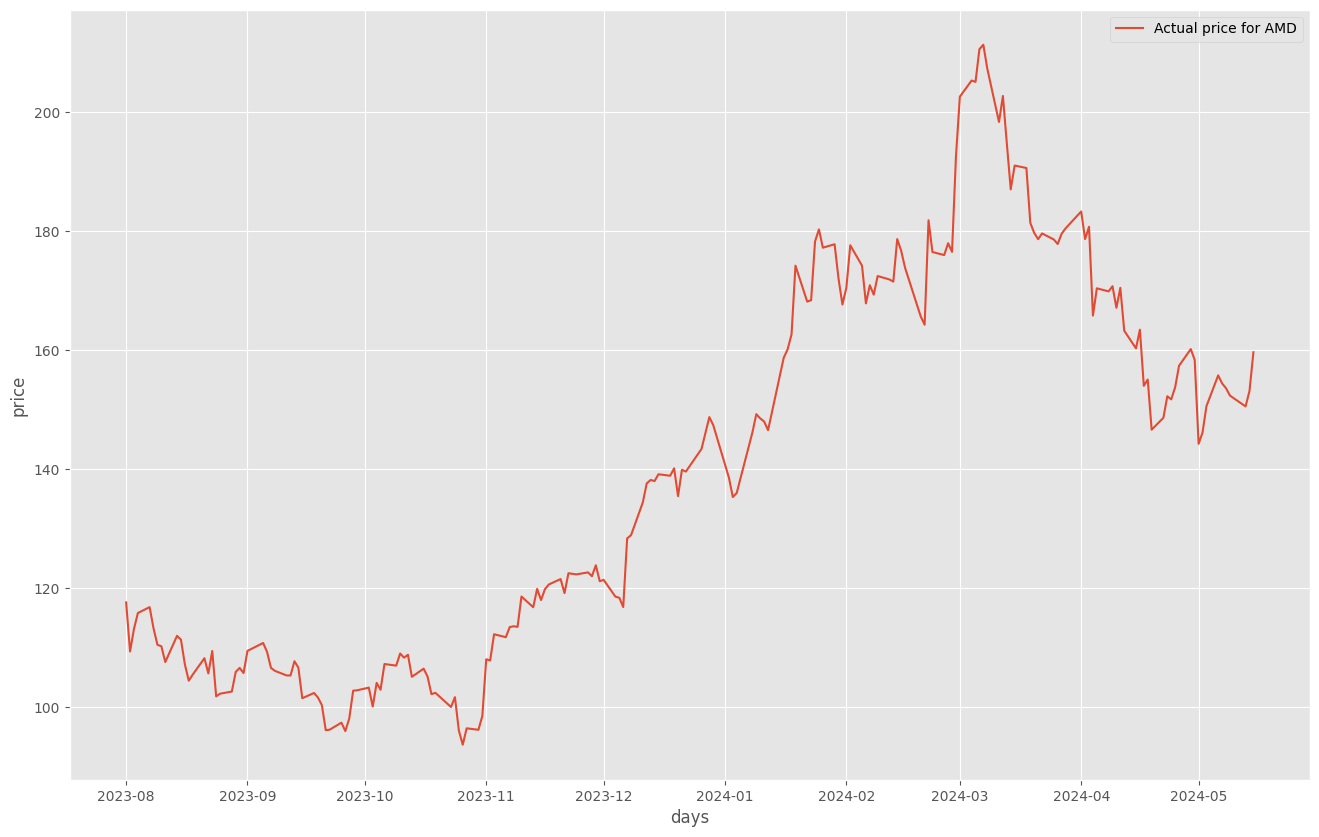

In [10]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(u01_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [11]:
# Scale data for ML engine
scaler = MinMaxScaler()
u01_df['scaled_close'] = scaler.fit_transform(np.expand_dims(u01_df['close'].values, axis=1))

In [12]:
u01_df

,close,date,scaled_close
2021-05-10,75.989998,2021-05-10,0.128989
2021-05-11,76.830002,2021-05-11,0.134393
2021-05-12,74.639999,2021-05-12,0.120304
2021-05-13,73.089996,2021-05-13,0.110332
2021-05-14,74.589996,2021-05-14,0.119982
...,...,...,...
2024-05-09,152.389999,2024-05-09,0.620497
2024-05-10,151.919998,2024-05-10,0.617473
2024-05-13,150.559998,2024-05-13,0.608724
2024-05-14,153.160004,2024-05-14,0.625450


In [13]:
def PrepareData(days):
  df = u01_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [14]:
PrepareData(3) # 5 days

(                 close       date  scaled_close    future
 2021-05-10   75.989998 2021-05-10      0.128989  0.110332
 2021-05-11   76.830002 2021-05-11      0.134393  0.119982
 2021-05-12   74.639999 2021-05-12      0.120304  0.120368
 2021-05-13   73.089996 2021-05-13      0.110332  0.119017
 2021-05-14   74.589996 2021-05-14      0.119982  0.130533
 ...                ...        ...           ...       ...
 2024-05-06  155.779999 2024-05-06      0.642306  0.620497
 2024-05-07  154.429993 2024-05-07      0.633621  0.617473
 2024-05-08  153.619995 2024-05-08      0.628410  0.608724
 2024-05-09  152.389999 2024-05-09      0.620497  0.625450
 2024-05-10  151.919998 2024-05-10      0.617473  0.667331
 
 [757 rows x 4 columns],
 array([[0.5804169 ],
        [0.60898095],
        [0.6423057 ],
        [0.6336206 ],
        [0.6284096 ],
        [0.62049663],
        [0.61747295],
        [0.6087236 ],
        [0.6254503 ],
        [0.6673314 ]], dtype=float32),
 array([[[0.1289886672033845

In [15]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [16]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 13s 14ms/step - loss: 0.0087
Epoch 2/80
95/95 [==============================] - 2s 16ms/step - loss: 0.0031
Epoch 3/80
95/95 [==============================] - 1s 15ms/step - loss: 0.0031
Epoch 4/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0026
Epoch 5/80
95/95 [==============================] - 1s 13ms/step - loss: 0.0024
Epoch 6/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0029
Epoch 7/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0020
Epoch 8/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0026
Epoch 9/80
95/95 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 10/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 11/80
95/95 [==============================] - 1s 12ms/step - loss: 0.0019
Epoch 12/80
95/95 [==============================] - 2s 20ms/step - loss: 0.0016
Epoch 13/80
95/95 [=================

1/1 [==============================] - 1s 682ms/step


In [17]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 5 days ({predictions_str})'

  print(message)

AMD prediction for upcoming 5 days (162.68$, 163.75$, 161.18$, 157.9$, 150.7$)


In [18]:
# Execute model for the whole history range
copy_u01_df = u01_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:7], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-4:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_u01_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 3ms/step


In [19]:
copy_u01_df

,close,date,scaled_close,predicted_close
2021-05-10,75.989998,2021-05-10,0.128989,77.860001
2021-05-11,76.830002,2021-05-11,0.134393,78.339996
2021-05-12,74.639999,2021-05-12,0.120304,78.419998
2021-05-13,73.089996,2021-05-13,0.110332,80.080002
2021-05-14,74.589996,2021-05-14,0.119982,80.809998
...,...,...,...,...
2024-05-09,152.389999,2024-05-09,0.620497,147.314728
2024-05-10,151.919998,2024-05-10,0.617473,151.919998
2024-05-13,150.559998,2024-05-13,0.608724,150.559998
2024-05-14,153.160004,2024-05-14,0.625450,153.160004


In [20]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_u01_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_u01_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_u01_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

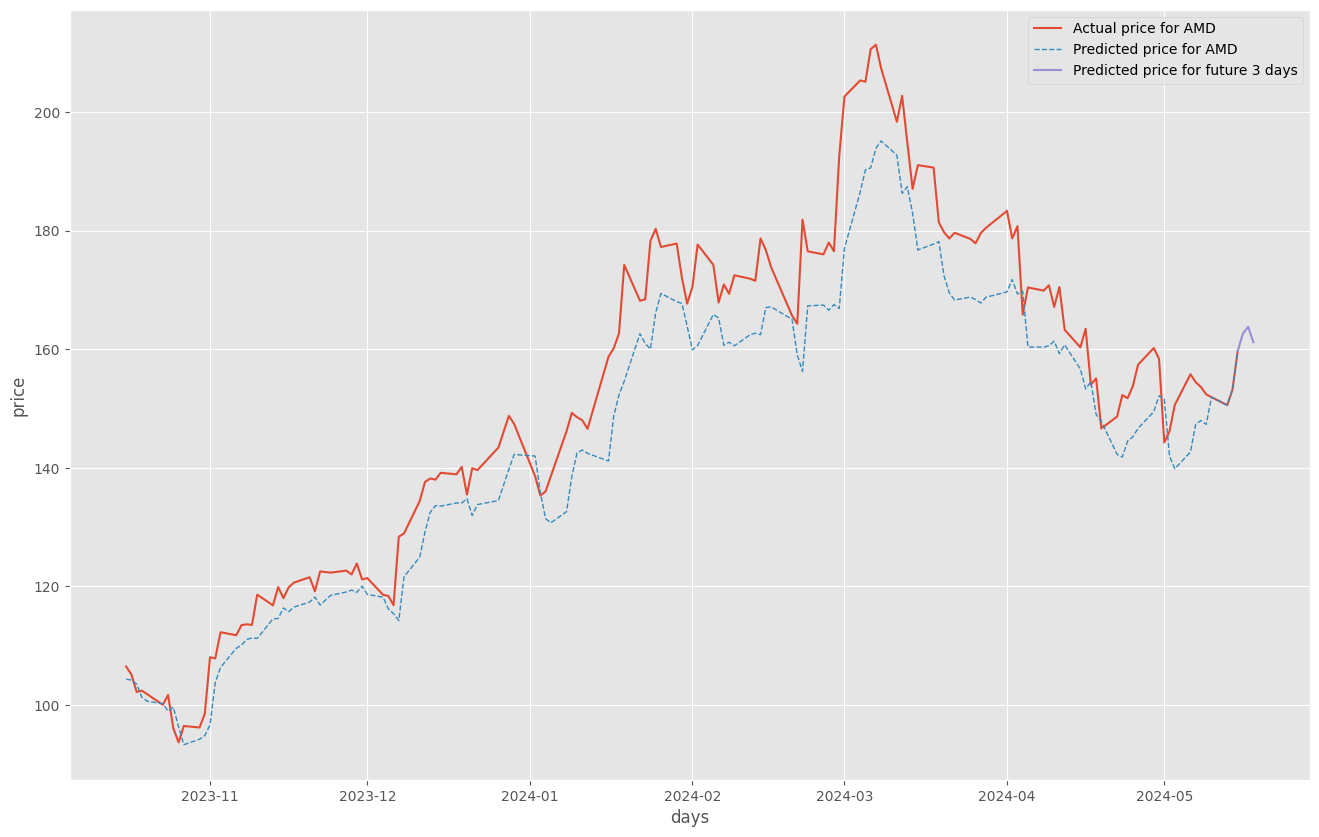

In [21]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_u01_df['close'][-150:].head(147))
plt.plot(copy_u01_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_u01_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()